# Predicting COVID case growth via Google Mobility Reports

In [262]:
import os
import pandas as pd
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import datetime
import logging
from NotebookScripter import receive_parameter
from datetime import datetime, timedelta

import matplotlib as mpl
mpl.rcParams.update({'figure.max_open_warning': 0})
logging.basicConfig(level=logging.INFO)

# the window width we look at for averaging mobility reports and measuring case growth.
window = 7


In [263]:
# https://www.google.com/covid19/mobility/
datapath = '../other3p/Region_Mobility_Report_CSVs/2020_US_Region_Mobility_Report.csv'    
    
raw_mobility = pd.read_csv(datapath)

raw_mobility = raw_mobility[raw_mobility['census_fips_code'].notnull()]

#raw_mobility['census_fips_code']=raw_mobility['census_fips_code'].astype(int)

raw_mobility['date'] = pd.to_datetime(raw_mobility['date'], format='%Y-%m-%d')

# the mobility reports indicate percentage change over a February baseline
raw_mobility

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
578,US,United States,Alabama,Autauga County,NaN,NaN,1001.0,2020-02-15,5.0,7.0,NaN,NaN,-4.0,NaN
579,US,United States,Alabama,Autauga County,NaN,NaN,1001.0,2020-02-16,0.0,1.0,-23.0,NaN,-4.0,NaN
580,US,United States,Alabama,Autauga County,NaN,NaN,1001.0,2020-02-17,8.0,0.0,NaN,NaN,-27.0,5.0
581,US,United States,Alabama,Autauga County,NaN,NaN,1001.0,2020-02-18,-2.0,0.0,NaN,NaN,2.0,0.0
582,US,United States,Alabama,Autauga County,NaN,NaN,1001.0,2020-02-19,-2.0,0.0,NaN,NaN,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727714,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,2020-11-23,NaN,NaN,NaN,NaN,-23.0,NaN
727715,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,2020-11-24,NaN,NaN,NaN,NaN,-21.0,NaN
727716,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,2020-11-25,NaN,NaN,NaN,NaN,-27.0,NaN
727717,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,2020-11-26,NaN,NaN,NaN,NaN,-73.0,NaN


Average the mobility reports over 7 days. 

The resulting rows will have dates corresponding to the end of the 7 day period.


In [264]:


feature_cols = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

# N/A values are interpreted as no change.
m=raw_mobility[['date','census_fips_code']+feature_cols].fillna(0).sort_values(['date']).groupby('census_fips_code').rolling(window)[feature_cols].mean().reset_index()
m.index=m['level_1']
raw_mobility = pd.merge(m, raw_mobility['date'], left_index=True, right_index=True)
#dates=pd.DataFrame(raw_mobility[['date','census_fips_code']].sort_values(['date']).groupby('census_fips_code')['date'])
#dates

#df['date']=dates

In [270]:
# Load the Johns Hopkins data

def load_raw(fn):
    datapath = os.path.join('../csse_covid_19_data/csse_covid_19_time_series/', fn)

    #datapath = '../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    
    raw = pd.read_csv(datapath)
    #del raw['Lat']
    #del raw['Long']
    #raw= raw.replace('Mainland China','China')
    raw = raw[raw.iso2=='US']
    raw = raw[pd.notnull(raw.UID) & ~(raw.Lat==0.0)]
    # fix HI/AK later
    raw = raw[~(raw.Province_State=='Alaska') & ~(raw.Province_State=='Hawaii')]
    return raw

raw = load_raw('time_series_covid19_confirmed_us.csv')
#raw_deaths = load_raw('time_series_covid19_deaths_global.csv')

raw

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,2704,2716,2735,2751,2780,2818,2873,2893,2945,2979
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,8576,8603,8733,8820,8890,9051,9163,9341,9501,9626
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,1170,1171,1173,1175,1178,1189,1206,1214,1217,1219
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,1170,1173,1179,1188,1196,1204,1239,1252,1270,1283
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,2879,2888,2922,2946,2997,3061,3100,3158,3231,3281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,84056037,US,USA,840,56037.0,Sweetwater,Wyoming,US,41.659439,-108.882788,...,1598,1774,1780,1812,1888,1903,1934,2024,2077,2098
3335,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,1476,1547,1570,1606,1644,1655,1678,1693,1724,1739
3336,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,1016,1037,1037,1046,1070,1089,1121,1149,1175,1187
3338,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,395,415,417,428,441,468,487,497,518,520


We look back at the last 36 weeks of data.  Using a rolling window, measure the last 7 days of case growth and compare it with the previous 7 days.  The rows are dated by the middle of the two-week period (this is the point at which we want to make predictions).  Finally, join with the mobility data.

In [266]:

weeks = 36
dates=raw.columns[-weeks*7:]
#print(dates)
threshold = 1000
# pct growth this week vs last
new = [(raw[dates[i]]-raw[dates[i-window]]).apply(lambda x: x if x>threshold else 0)/(raw[dates[i-window]]-raw[dates[i-2*window]]).apply(lambda x: x if x>0 else 1) for i in range(2*window,len(dates))]
date_shift = [datetime.strptime(d, '%m/%d/%y') for d in dates[window:]]
#print(date_shift)
dates = dates[2*window:]

print(raw_mobility.columns)

new = [list(zip(raw['FIPS'],n)) for n in new]
new = [(f,d,ds,v) for (n,(d,ds)) in zip(new,zip(dates,date_shift)) for (f,v) in n]
new = pd.DataFrame(new, columns=['census_fips_code', 'end_date', 'date', 'Growth'])

print(new.shape, raw_mobility.shape)


regression_data = pd.merge(raw_mobility, new, on=['census_fips_code','date'])

#exploded = [(, dates[j], new_row) for j in range(len(dates)) for raw_row,new_row in zip(raw,new[j])]

#exploded


Index(['census_fips_code', 'level_1',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'date'],
      dtype='object')
(741608, 4) (712980, 9)


Train the model.  Initially I experimented with linear regressors, but these did a poor job so I switched to a random forest regressor and did some minimal parameter sweeps.  Note there's quite a bit of overfitting (see the two score outputs), but these parameters still perform best.

(16241, 6) 16241
0.9382974195005079
0.5868543850608773


Text(0, 0.5, 'Predicted growth')

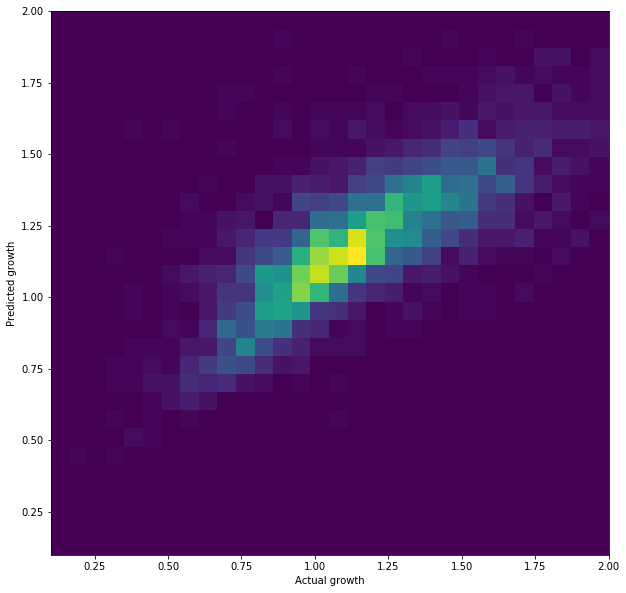

In [267]:

regression_data = pd.merge(raw_mobility, new, on=['census_fips_code','date'])


# remove outliers: drops of more than 90% or week over week growth of more than 300%
regression_data=regression_data[regression_data['Growth']>0.1]
regression_data=regression_data[regression_data['Growth']<4]
#regression_data=regression_data[regression_data['Growth']!=1.0]

regression_data

#col = 'retail_and_recreation_percent_change_from_baseline'

#plottable = regression_data[regression_data[col].notnull()]
#x = plottable[col]
#y = plottable['Growth']
plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
#ax.scatter(x,y)   
#ax.set_yscale('log')


#model = np.polyfit(plottable[col],plottable['Growth'],1)
#model_x = np.array([[min(x),1],[max(x),1]])
#model_y = np.power(10,model_x.dot(model))
#model_y = model_x.dot(model)
#logging.debug(f"{model_x},{model_y}")
#print(model_x)
#ax.plot(model_x[:,0], model_y, linestyle='--')
#print(model)


feature_cols = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

x = regression_data[feature_cols].fillna(0)
y = regression_data['Growth']

# stratify by FIPS code so no county is split between train and test.
strat = {}
for f in regression_data['census_fips_code']:
    if f not in strat:
        strat[f]=len(strat)%5

strat = [strat[f] for f in regression_data['census_fips_code']]

print(x.shape, len(regression_data))
#x = np.concatenate((x, np.ones((len(regression_data),1))), axis=1)
#print(x.shape)

from sklearn.linear_model import LinearRegression,BayesianRidge #,TweedieRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
#print(strat)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify=strat)

#model = LinearRegression(fit_intercept=True)
#model = BayesianRidge(fit_intercept=True)
#model = TweedieRegressor(power=1, alpha=0.5, link='log')
#model = DecisionTreeRegressor(max_depth=8, min_samples_leaf=2, random_state=3)

param_grid = { 'n_estimators': [10, 20, 50, 100, 200], 'min_samples_leaf':[1,2,10,100], 'max_samples':[0.8]}
#model = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, verbose=2)
model = RandomForestRegressor(n_estimators=200, min_samples_leaf=1)# max_samples=1.0)


model.fit(x_train, y_train)
#df = pd.DataFrame(model.coef_, feature_cols, columns = ['Coeff'])
#print(model.coef_, model.intercept_)

# Compare scores on train vs test.  Overfitting!
print(model.score(x_train,y_train))
print(model.score(x_test,y_test))
#print(df)

#print(list(sorted(zip(feature_cols,model.coef_), key=lambda x: x[1], reverse=True)))

predictions = model.predict(x_test)
result=plt.hist2d(y_test, predictions,[30,30], range=[[0.1,2.0],[0.1,2.0]])
plt.xlabel('Actual growth')
plt.ylabel('Predicted growth')


['retail and recreation', 'grocery and pharmacy', 'parks', 'transit stations', 'workplaces', 'residential']


([0, 1, 2, 3, 4, 5], <a list of 6 Text xticklabel objects>)

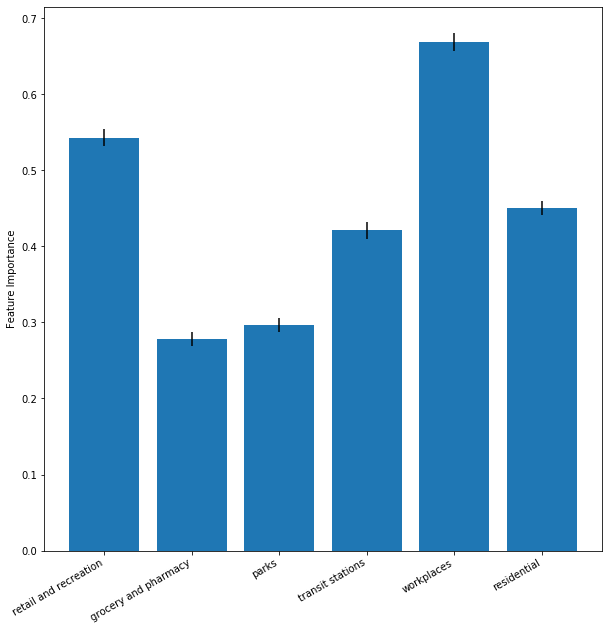

In [268]:
#print(model.best_params_, model.best_score_)

# Use permutation importance to measure approximate feature importance. I used the test set, but train could be used too.

from sklearn.inspection import permutation_importance
result = permutation_importance(model, x_test, y_test, n_repeats=10, random_state=0)#
#result
fcols = [' '.join(f.split('_')[:-4]) for f in feature_cols]
print(fcols)
plt.bar(fcols, result.importances_mean, yerr=result.importances_std)
plt.ylabel('Feature Importance')
plt.xticks(rotation=30, ha='right')